# Day 5: Distance Metrics for Financial Data

## 🎯 Learning Objectives
- Compare distance metrics for financial applications
- Understand Mahalanobis distance
- Apply DTW for time series similarity
- Build similarity-based trading strategies

---

## 📚 Theory: Distance Metrics

| Metric | Formula | Use Case |
|--------|---------|----------|
| Euclidean | $\sqrt{\sum(x_i-y_i)^2}$ | General purpose |
| Manhattan | $\sum|x_i-y_i|$ | Outlier robust |
| Mahalanobis | $\sqrt{(x-y)^T\Sigma^{-1}(x-y)}$ | Correlated features |
| Cosine | $1 - \frac{x \cdot y}{||x|| ||y||}$ | Direction similarity |
| DTW | Dynamic time warping | Time series |

---

In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from scipy.spatial.distance import cdist, mahalanobis
from scipy.linalg import inv

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1254 days


In [26]:
# Create features
df = pd.DataFrame(index=prices.index)
df['return'] = returns

for lag in [1, 5, 10, 20]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

df['volatility_10'] = returns.rolling(10).std()
df['volatility_20'] = returns.rolling(20).std()
df['ma_ratio'] = prices / prices.rolling(20).mean() - 1

# Target
df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
feature_cols = [c for c in df.columns if c not in ['return', 'next_return', 'target']]

print(f"📊 Features: {len(feature_cols)}, Samples: {len(df)}")

📊 Features: 7, Samples: 1233


In [27]:
# Prepare data
X = df[feature_cols]
y = df['target']

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 986, Test: 247


In [28]:
# Compare distance metrics in kNN
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

print("\n" + "="*60)
print("KNN PERFORMANCE BY DISTANCE METRIC")
print("="*60)

results = []
predictions = {}

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=10, metric=metric)
    knn.fit(X_train_scaled, y_train)
    
    y_pred = knn.predict(X_test_scaled)
    predictions[metric] = y_pred
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({'Metric': metric, 'Accuracy': acc, 'F1': f1})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


KNN PERFORMANCE BY DISTANCE METRIC
   Metric  Accuracy       F1
euclidean  0.437247 0.446215
manhattan  0.441296 0.448000
chebyshev  0.457490 0.480620
minkowski  0.437247 0.446215


In [29]:
# Mahalanobis distance implementation
cov_matrix = np.cov(X_train_scaled.T)
cov_inv = inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6)  # Regularize

def mahalanobis_knn(X_train, y_train, X_test, cov_inv, k=10):
    """kNN with Mahalanobis distance"""
    predictions = []
    
    for test_point in X_test:
        distances = []
        for train_point in X_train:
            diff = test_point - train_point
            dist = np.sqrt(diff.T @ cov_inv @ diff)
            distances.append(dist)
        
        # Get k nearest neighbors
        nearest_idx = np.argsort(distances)[:k]
        nearest_labels = y_train.iloc[nearest_idx]
        prediction = nearest_labels.mode().iloc[0]
        predictions.append(prediction)
    
    return np.array(predictions)

print("\n⏳ Computing Mahalanobis kNN (may take a moment)...")
y_pred_maha = mahalanobis_knn(X_train_scaled, y_train, X_test_scaled[:100], cov_inv, k=10)
acc_maha = accuracy_score(y_test[:100], y_pred_maha)
print(f"\nMahalanobis kNN Accuracy (first 100 test): {acc_maha:.2%}")


⏳ Computing Mahalanobis kNN (may take a moment)...



Mahalanobis kNN Accuracy (first 100 test): 46.00%


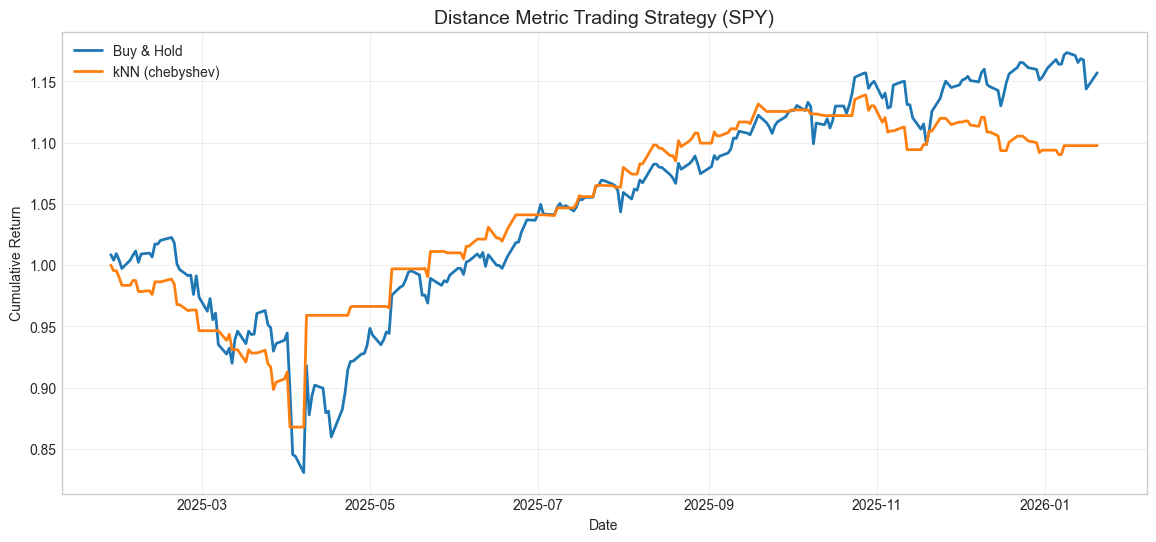

In [30]:
# Trading backtest
best_metric = results_df.loc[results_df['Accuracy'].idxmax(), 'Metric']
y_pred = predictions[best_metric]

backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values
backtest['signal'] = y_pred
backtest['strategy_return'] = backtest['signal'] * backtest['actual_return']

backtest['strategy_cum'] = (1 + backtest['strategy_return']).cumprod()
backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['strategy_cum'], label=f'kNN ({best_metric})', linewidth=2)
plt.title(f'Distance Metric Trading Strategy ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd = calc_metrics(backtest['actual_return'], backtest['buy_hold_cum'])
st_total, st_sharpe, st_mdd = calc_metrics(backtest['strategy_return'], backtest['strategy_cum'])

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)
print(f"{'Buy & Hold':<20} {bh_total:>12.2%} {bh_sharpe:>10.2f} {bh_mdd:>10.2%}")
print(f"{f'kNN ({best_metric})':<20} {st_total:>12.2%} {st_sharpe:>10.2f} {st_mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                 15.70%       0.60    -18.76%
kNN (chebyshev)             9.75%       0.38    -13.21%


In [32]:
# Next day prediction
knn = KNeighborsClassifier(n_neighbors=10, metric=best_metric)
knn.fit(X_train_scaled, y_train)

latest_scaled = scaler.transform(X.iloc[[-1]])
pred = knn.predict(latest_scaled)[0]
proba = knn.predict_proba(latest_scaled)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Best Distance Metric: {best_metric}")
print(f"\nPrediction: {'📈 UP' if pred == 1 else '📉 DOWN'}")
print(f"Probability: Down={proba[0]:.1%}, Up={proba[1]:.1%}")


📊 NEXT DAY PREDICTION FOR SPY

Date: 2026-01-20
Best Distance Metric: chebyshev

Prediction: 📉 DOWN
Probability: Down=50.0%, Up=50.0%


---

## 🏢 Real-World Applications

| Company | Distance Metric Use Case |
|---------|-------------------------|
| AQR | Factor similarity |
| Two Sigma | Regime matching |
| Citadel | Cross-asset relationships |

### Key Interview Points
1. **When Mahalanobis?** - Correlated features, different scales
2. **Cosine vs Euclidean?** - Cosine for direction, Euclidean for magnitude
3. **DTW?** - Time series with different speeds

---
## 📅 Tomorrow: Locality Sensitive Hashing